<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3095533551.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('final_merged_data.csv', parse_dates=['Date'], index_col='Date')



After Filling - Missing Dates Check:
No missing dates after filling.
Data Shape: (976, 41)

Data Types:
 Calls                       float64
^VIX_Close_^VIX             float64
^VIX_High_^VIX              float64
^VIX_Low_^VIX               float64
^VIX_Open_^VIX              float64
^VIX_Volume_^VIX            float64
BVOL-USD_Close_BVOL-USD     float64
BVOL-USD_High_BVOL-USD      float64
BVOL-USD_Low_BVOL-USD       float64
BVOL-USD_Open_BVOL-USD      float64
BVOL-USD_Volume_BVOL-USD    float64
CVOL-USD_Close_CVOL-USD     float64
CVOL-USD_High_CVOL-USD      float64
CVOL-USD_Low_CVOL-USD       float64
CVOL-USD_Open_CVOL-USD      float64
CVOL-USD_Volume_CVOL-USD    float64
CVX-USD_Close_CVX-USD       float64
CVX-USD_High_CVX-USD        float64
CVX-USD_Low_CVX-USD         float64
CVX-USD_Open_CVX-USD        float64
CVX-USD_Volume_CVX-USD      float64
SPY_Close_SPY               float64
SPY_High_SPY                float64
SPY_Low_SPY                 float64
SPY_Open_SPY                fl

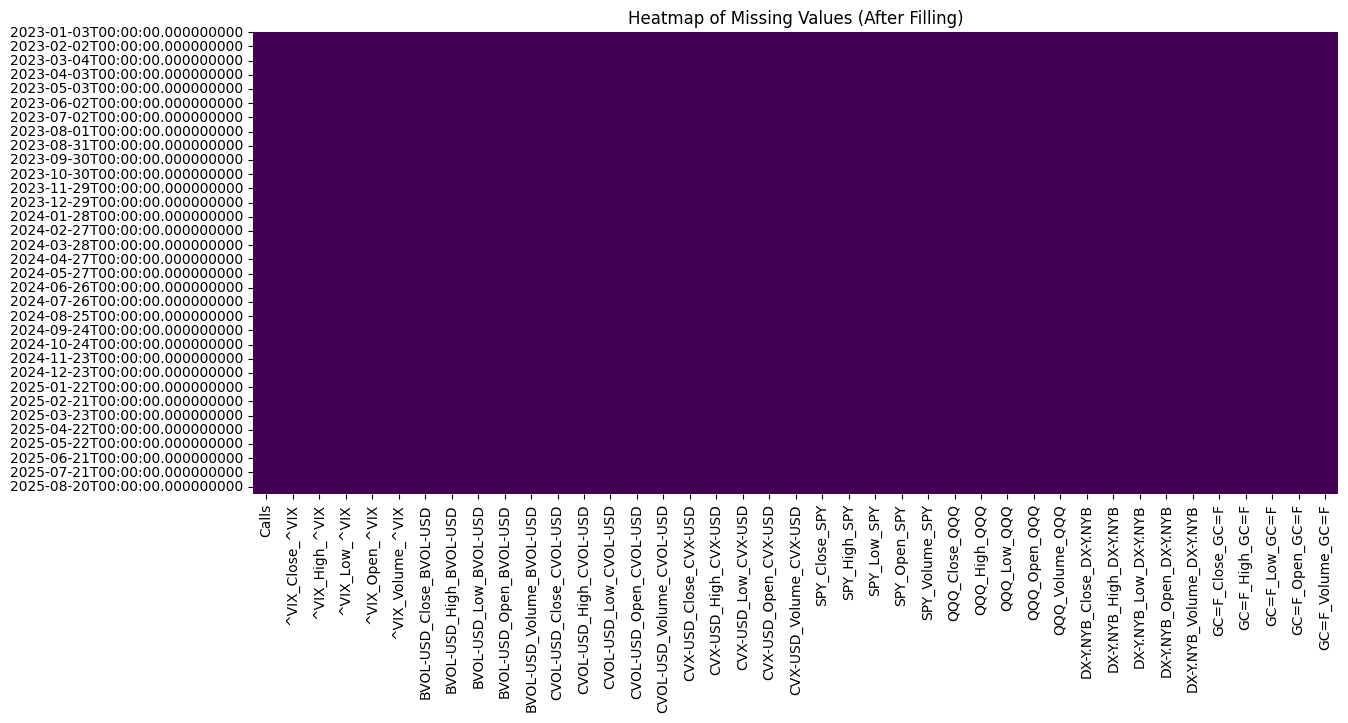

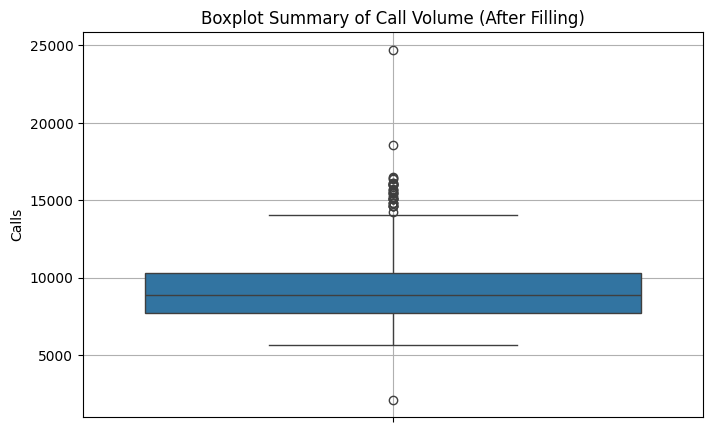

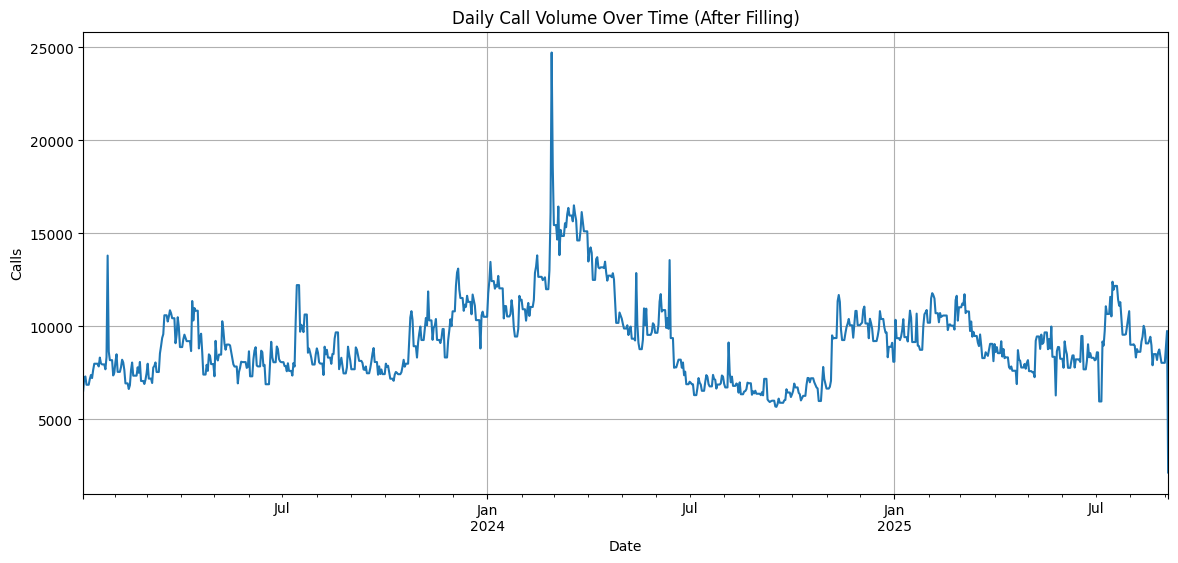

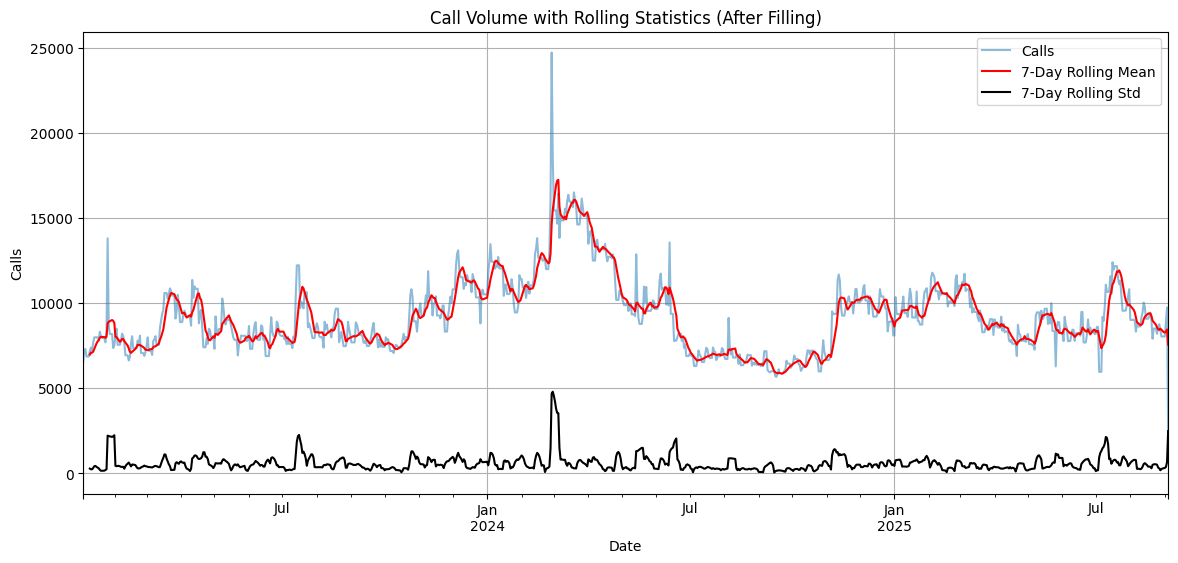

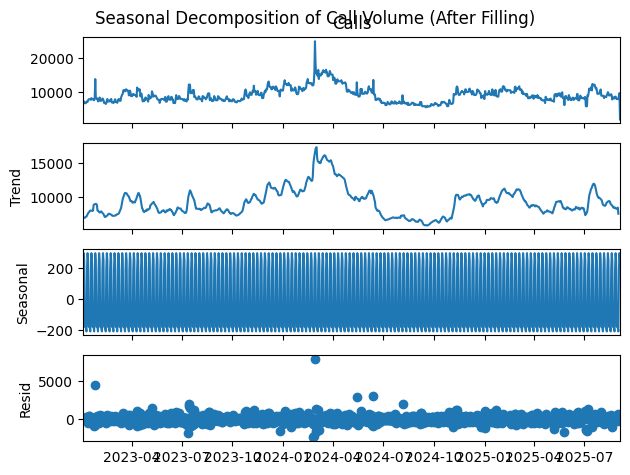

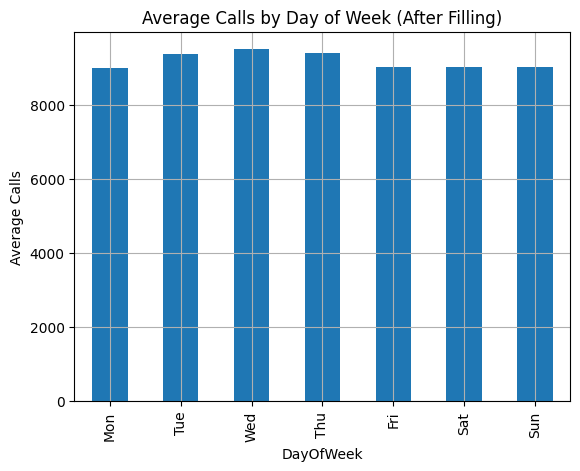

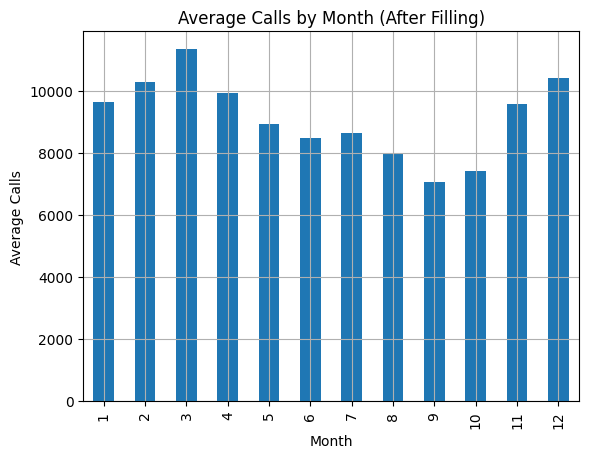

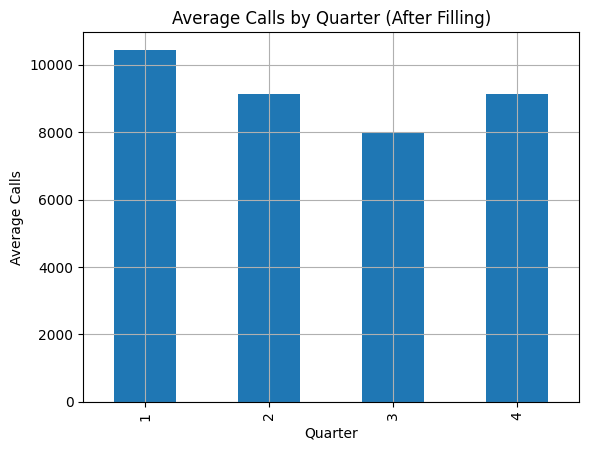

<Figure size 1400x600 with 0 Axes>

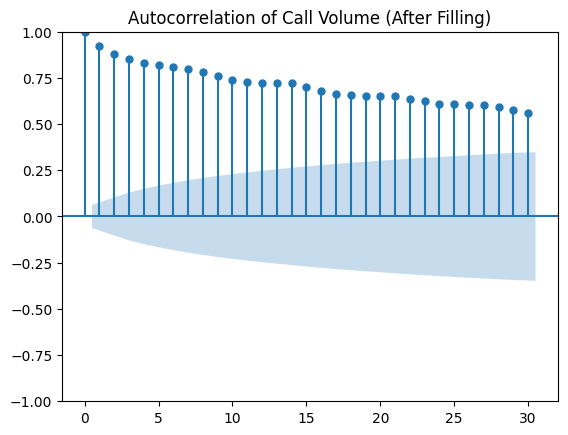

<Figure size 1400x600 with 0 Axes>

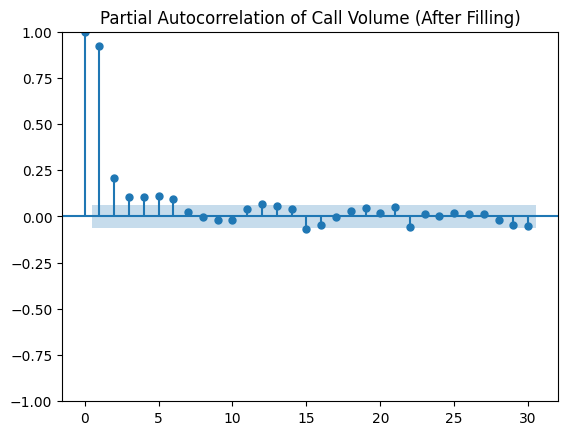


ADF Statistic: -2.5851286697797495
p-value: 0.09610998717434743
Critical Values: {'1%': np.float64(-3.437180074590612), '5%': np.float64(-2.8645553686071326), '10%': np.float64(-2.5683755479600694)}
Series is non-stationary (fail to reject null hypothesis)

ADF on Differenced Series: -7.631644597214239
p-value: 2.0015457080726773e-11


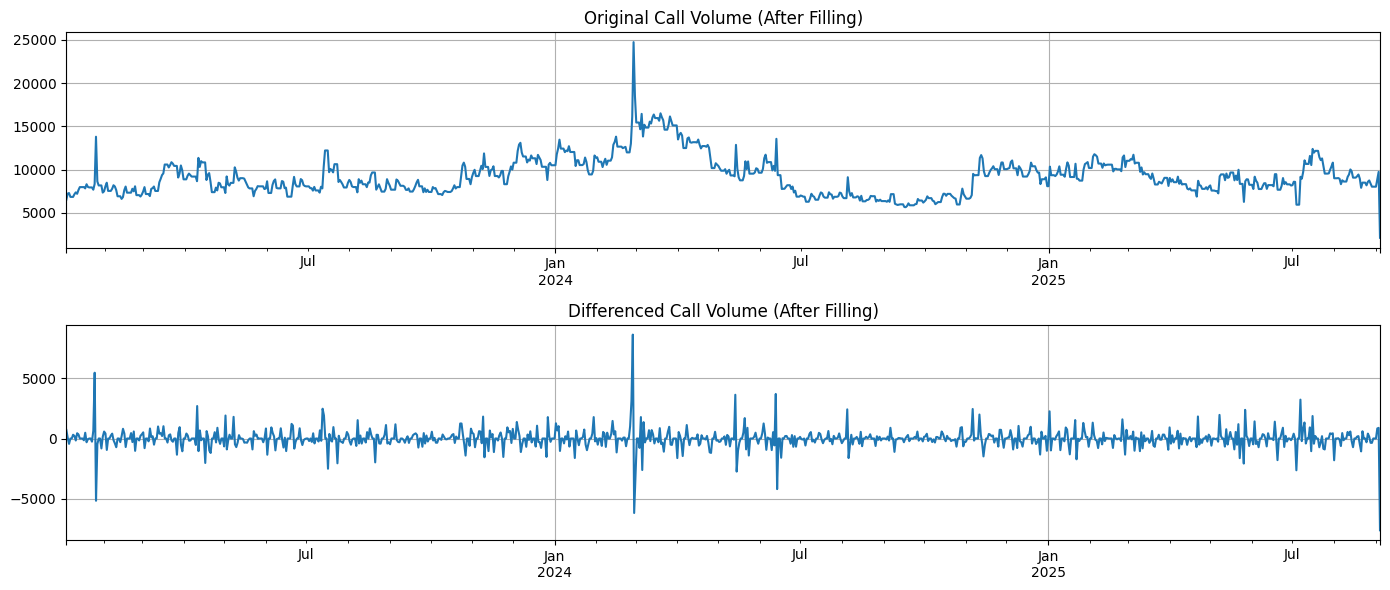


Correlations with Calls:
 Calls                       1.000000
CVOL-USD_Close_CVOL-USD     0.244022
CVOL-USD_Low_CVOL-USD       0.243937
CVOL-USD_Open_CVOL-USD      0.237423
CVOL-USD_High_CVOL-USD      0.233865
CVX-USD_High_CVX-USD        0.219517
CVX-USD_Open_CVX-USD        0.217723
CVX-USD_Close_CVX-USD       0.209759
CVX-USD_Low_CVX-USD         0.198598
DX-Y.NYB_Low_DX-Y.NYB       0.173362
DX-Y.NYB_Close_DX-Y.NYB     0.173266
DX-Y.NYB_High_DX-Y.NYB      0.166536
DX-Y.NYB_Open_DX-Y.NYB      0.165364
QQQ_Low_QQQ                 0.076920
QQQ_Open_QQQ                0.075847
QQQ_Close_QQQ               0.074567
QQQ_High_QQQ                0.073244
SPY_Volume_SPY              0.062863
CVX-USD_Volume_CVX-USD      0.062659
SPY_Low_SPY                 0.039556
SPY_Open_SPY                0.038181
SPY_Close_SPY               0.037072
SPY_High_SPY                0.035189
GC=F_Volume_GC=F            0.020522
QQQ_Volume_QQQ              0.009128
BVOL-USD_Low_BVOL-USD      -0.034412
DayOfWeek  

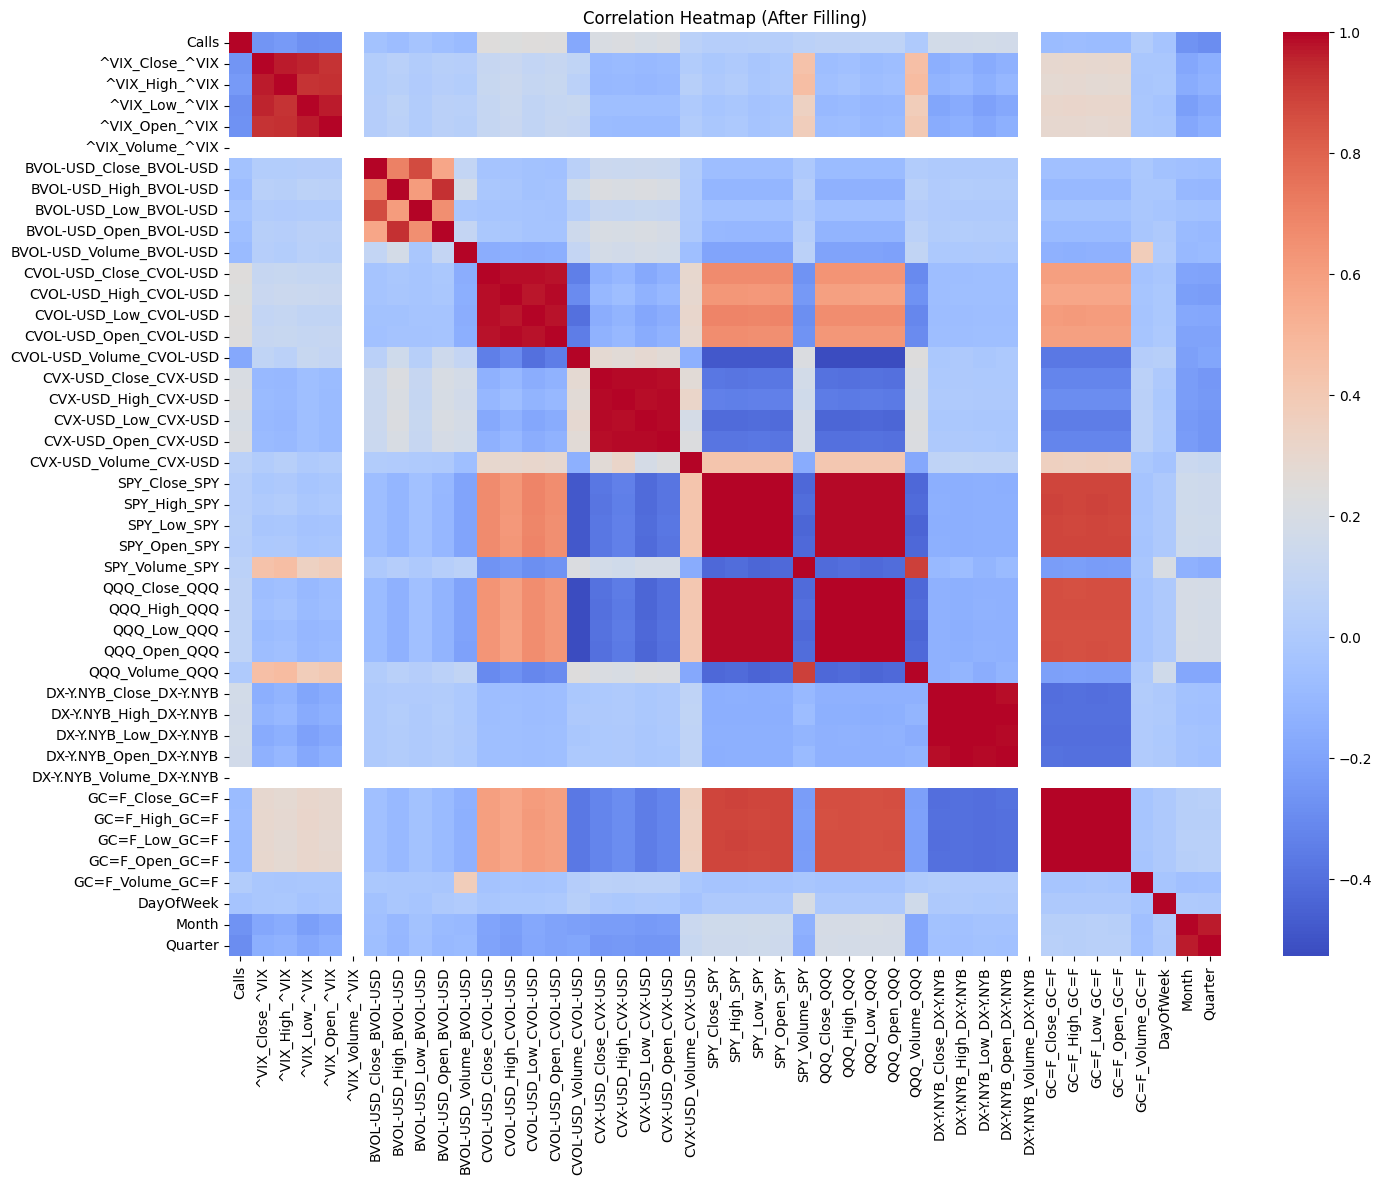


Features with |corr| > 0.2: Index(['^VIX_Close_^VIX', '^VIX_High_^VIX', '^VIX_Low_^VIX', '^VIX_Open_^VIX',
       'CVOL-USD_Close_CVOL-USD', 'CVOL-USD_High_CVOL-USD',
       'CVOL-USD_Low_CVOL-USD', 'CVOL-USD_Open_CVOL-USD',
       'CVX-USD_Close_CVX-USD', 'CVX-USD_High_CVX-USD', 'CVX-USD_Open_CVX-USD',
       'Month', 'Quarter'],
      dtype='object')


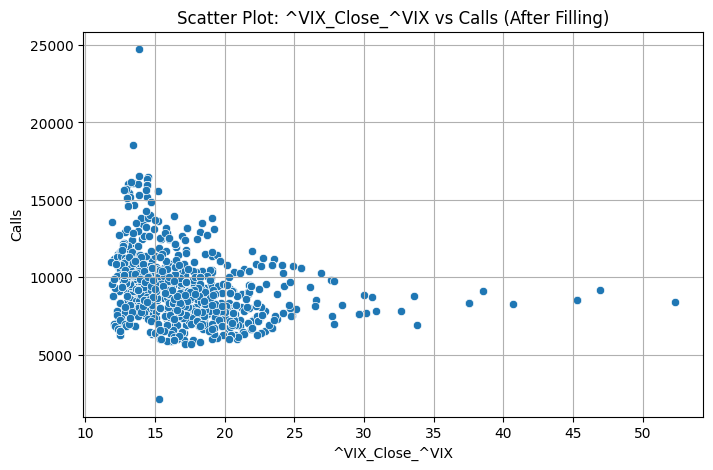

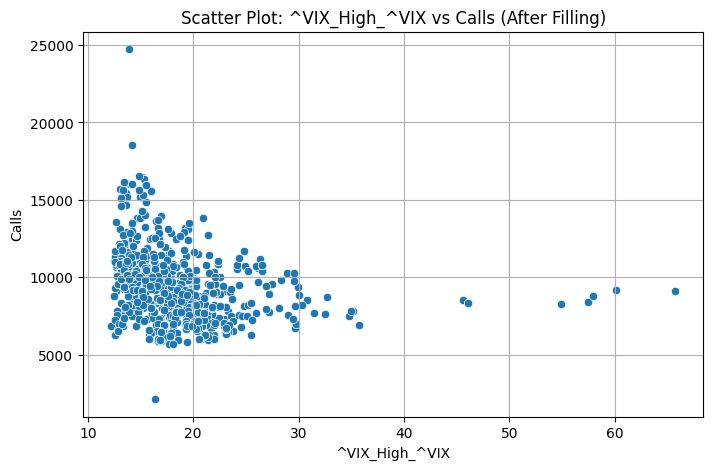

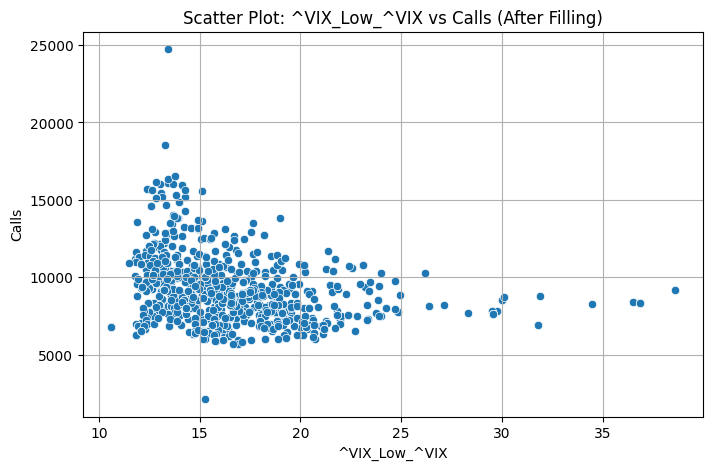

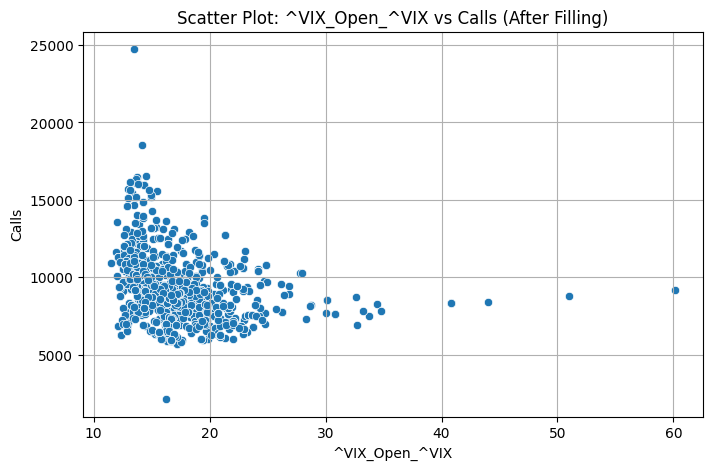

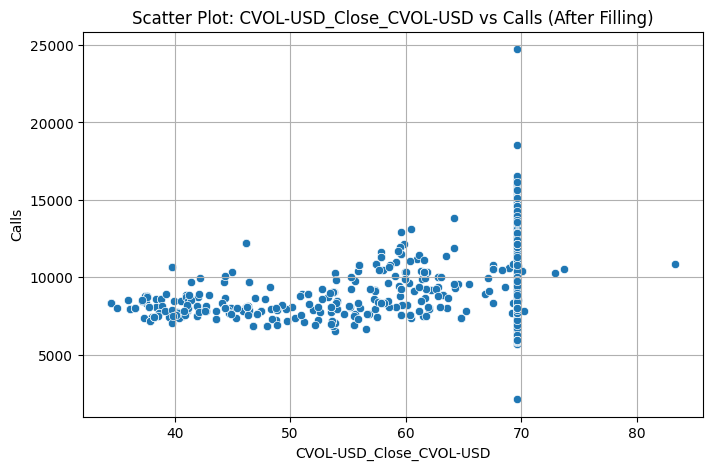

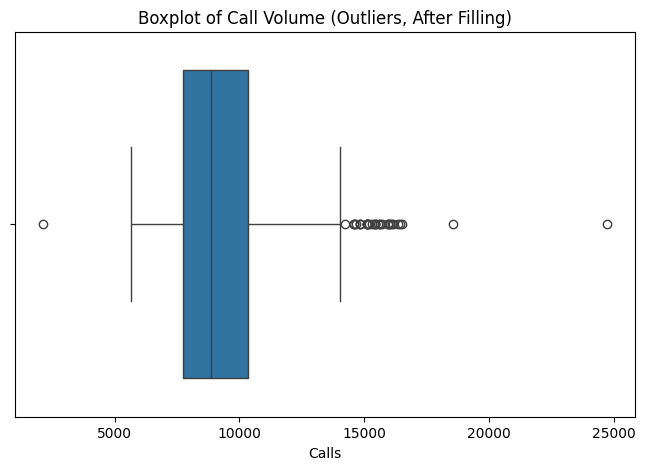


Outliers (Z-score > 3):
               Calls
2024-02-27  16109.0
2024-02-28  24724.0
2024-02-29  18546.0
2024-03-05  16441.0
2024-03-13  16024.0
2024-03-14  16367.0
2024-03-15  15956.0
2024-03-16  15956.0
2024-03-17  15956.0
2024-03-19  16505.0
2024-03-20  16049.0
2024-03-21  15708.0
2024-03-26  16144.0
2025-09-04   2136.0

IQR Outliers:
               Calls
2024-02-27  16109.0
2024-02-28  24724.0
2024-02-29  18546.0
2024-03-01  15442.0
2024-03-02  15442.0
2024-03-03  15442.0
2024-03-04  14664.0
2024-03-05  16441.0
2024-03-07  15186.0
2024-03-08  14858.0
2024-03-09  14858.0
2024-03-10  14858.0
2024-03-11  15543.0
2024-03-12  15327.0
2024-03-13  16024.0
2024-03-14  16367.0
2024-03-15  15956.0
2024-03-16  15956.0
2024-03-17  15956.0
2024-03-18  15646.0
2024-03-19  16505.0
2024-03-20  16049.0
2024-03-21  15708.0
2024-03-22  14617.0
2024-03-23  14617.0
2024-03-24  14617.0
2024-03-25  15173.0
2024-03-26  16144.0
2024-03-27  15641.0
2024-03-28  15108.0
2024-03-29  15108.0
2024-03-30  15108.

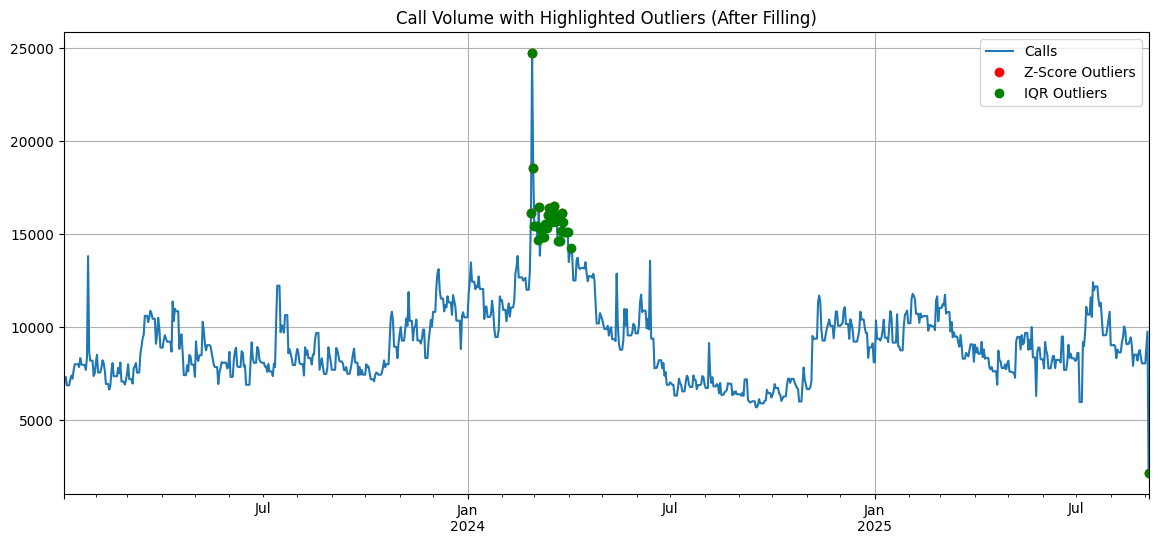


Avg Calls on High VIX (>20): 8188.949438202248
Avg Calls on Low VIX (<=20): 9419.946115288221


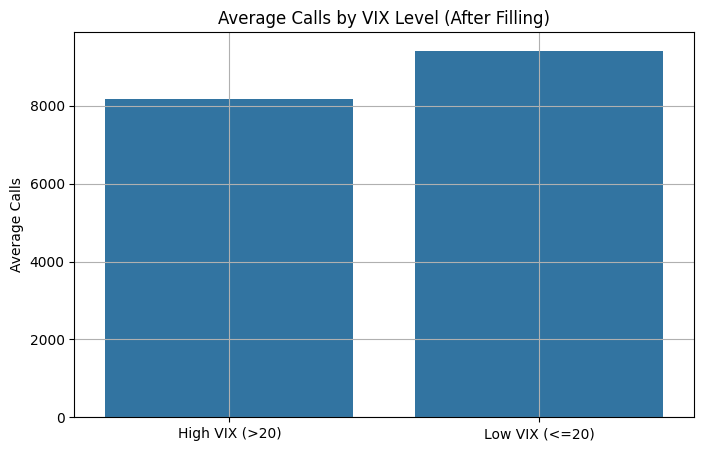

Avg Calls on High CVOL: 9999.444444444445
Avg Calls on Low CVOL: 9187.957600827302


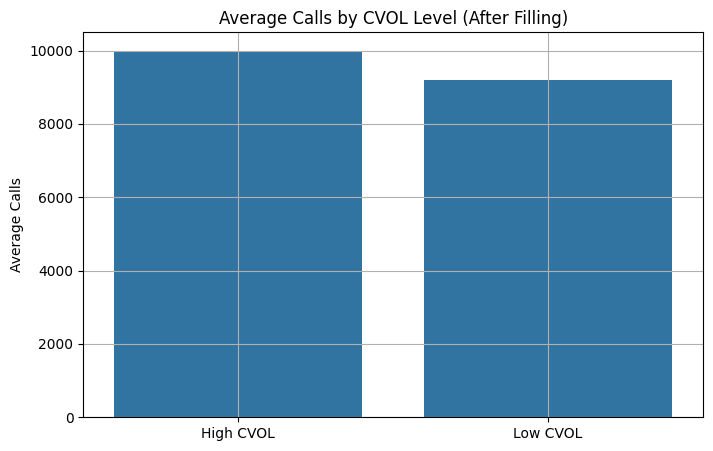

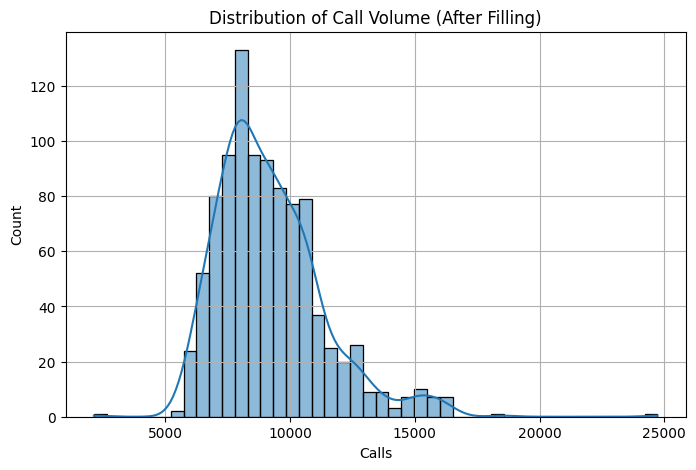

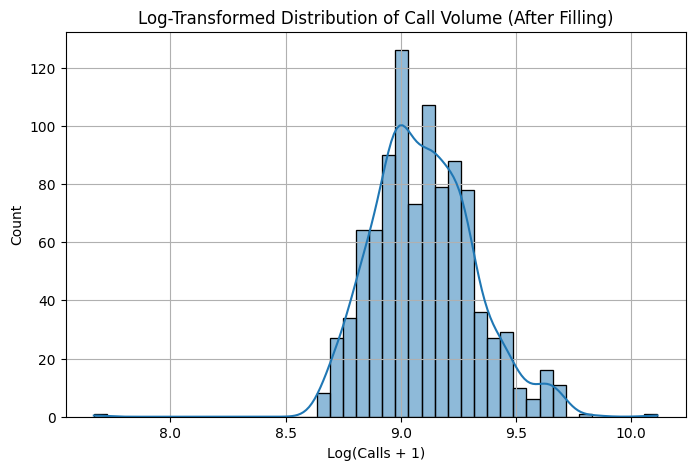


Revised EDA Complete. Data now includes filled values for weekends and holidays using forward-fill.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Step 1: Load the data from CSV file
df = pd.read_csv('final_merged_data.csv', parse_dates=['Date'], index_col='Date')

# Rename the dependent variable for simplicity
df = df.rename(columns={'V Cx Contact Volume Template Contacts': 'Calls'})

# New Step: Fill missing dates (weekends and holidays) with forward-fill from last business day
# Create full daily date range from min to max date
min_date = df.index.min()
max_date = df.index.max()
full_range = pd.date_range(start=min_date, end=max_date, freq='D')

# Reindex to full range and forward-fill all columns
df = df.reindex(full_range).ffill()

# Verify no missing dates now
print("\nAfter Filling - Missing Dates Check:")
date_range_check = pd.date_range(start=min_date, end=max_date)
missing_after = date_range_check.difference(df.index)
if missing_after.empty:
    print("No missing dates after filling.")
else:
    print("Still missing:", missing_after)

# Proceed with EDA on the filled DataFrame

# Step 2: Basic Overview
print("Data Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nSummary Statistics for Calls:\n", df['Calls'].describe())
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique Dates:", len(df.index.unique()))  # Check for duplicates or gaps

# Visualization for missing values (should be none after fill)
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values (After Filling)')
plt.show()

# Visualization for summary statistics (boxplot for Calls)
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['Calls'])
plt.title('Boxplot Summary of Call Volume (After Filling)')
plt.ylabel('Calls')
plt.grid(True)
plt.show()

# Step 3: Visualize the Time Series
plt.figure(figsize=(14, 6))
df['Calls'].plot(title='Daily Call Volume Over Time (After Filling)')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.grid(True)
plt.show()

# Rolling mean and std (7-day window for weekly smoothing)
rolling_mean = df['Calls'].rolling(window=7).mean()
rolling_std = df['Calls'].rolling(window=7).std()

plt.figure(figsize=(14, 6))
df['Calls'].plot(label='Calls', alpha=0.5)
rolling_mean.plot(label='7-Day Rolling Mean', color='red')
rolling_std.plot(label='7-Day Rolling Std', color='black')
plt.title('Call Volume with Rolling Statistics (After Filling)')
plt.xlabel('Date')
plt.ylabel('Calls')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Time Series Decomposition (assuming weekly seasonality, period=7)
decomp = seasonal_decompose(df['Calls'], model='additive', period=7)
decomp.plot()
plt.suptitle('Seasonal Decomposition of Call Volume (After Filling)')
plt.show()

# Step 5: Seasonality and Patterns
# Add day of week, month, quarter
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter

# Average calls by day of week
dow_avg = df.groupby('DayOfWeek')['Calls'].mean()
dow_avg.plot(kind='bar', title='Average Calls by Day of Week (After Filling)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Average Calls')
plt.grid(True)
plt.show()

# Average calls by month
month_avg = df.groupby('Month')['Calls'].mean()
month_avg.plot(kind='bar', title='Average Calls by Month (After Filling)')
plt.ylabel('Average Calls')
plt.grid(True)
plt.show()

# Average calls by quarter
quarter_avg = df.groupby('Quarter')['Calls'].mean()
quarter_avg.plot(kind='bar', title='Average Calls by Quarter (After Filling)')
plt.ylabel('Average Calls')
plt.grid(True)
plt.show()

# Step 6: Autocorrelation and Partial Autocorrelation
plt.figure(figsize=(14, 6))
plot_acf(df['Calls'], lags=30, title='Autocorrelation of Call Volume (After Filling)')
plt.show()

plt.figure(figsize=(14, 6))
plot_pacf(df['Calls'], lags=30, title='Partial Autocorrelation of Call Volume (After Filling)')
plt.show()

# Step 7: Stationarity Test (ADF Test)
adf_result = adfuller(df['Calls'])
print('\nADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])
if adf_result[1] > 0.05:
    print("Series is non-stationary (fail to reject null hypothesis)")
else:
    print("Series is stationary (reject null hypothesis)")

# Plot original and differenced series for visualization
diff_calls = df['Calls'].diff().dropna()
adf_diff = adfuller(diff_calls)
print('\nADF on Differenced Series:', adf_diff[0])
print('p-value:', adf_diff[1])

plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
df['Calls'].plot(title='Original Call Volume (After Filling)')
plt.grid(True)

plt.subplot(2, 1, 2)
diff_calls.plot(title='Differenced Call Volume (After Filling)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Correlations with Market Features
# Select numeric columns only
numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()
print("\nCorrelations with Calls:\n", corr_matrix['Calls'].sort_values(ascending=False))

# Heatmap of correlations
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap (After Filling)')
plt.show()

# Focus on high correlations (abs > 0.2)
high_corr = corr_matrix['Calls'][abs(corr_matrix['Calls']) > 0.2].index.drop('Calls', errors='ignore')
print("\nFeatures with |corr| > 0.2:", high_corr)

# Scatter plots for key correlated features
for col in high_corr[:5]:  # Top 5 for brevity
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df[col], y=df['Calls'])
    plt.title(f'Scatter Plot: {col} vs Calls (After Filling)')
    plt.grid(True)
    plt.show()

# Step 9: Outlier Detection
# Boxplot for Calls
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Calls'])
plt.title('Boxplot of Call Volume (Outliers, After Filling)')
plt.show()

# Z-score outliers
z_scores = np.abs((df['Calls'] - df['Calls'].mean()) / df['Calls'].std())
outliers = df[z_scores > 3]
print("\nOutliers (Z-score > 3):\n", outliers[['Calls']])

# IQR outliers
Q1 = df['Calls'].quantile(0.25)
Q3 = df['Calls'].quantile(0.75)
IQR = Q3 - Q1
iqr_outliers = df[(df['Calls'] < (Q1 - 1.5 * IQR)) | (df['Calls'] > (Q3 + 1.5 * IQR))]
print("\nIQR Outliers:\n", iqr_outliers[['Calls']])

# Visualization: Highlight outliers in time series
plt.figure(figsize=(14, 6))
df['Calls'].plot(label='Calls')
outliers['Calls'].plot(style='ro', label='Z-Score Outliers')
iqr_outliers['Calls'].plot(style='go', label='IQR Outliers')
plt.title('Call Volume with Highlighted Outliers (After Filling)')
plt.legend()
plt.grid(True)
plt.show()

# Step 10: Additional Analysis - High/Low Volatility Days
# Example: Average calls on high VIX days (>20) vs low
high_vix = df[df['^VIX_Close_^VIX'] > 20]['Calls'].mean()
low_vix = df[df['^VIX_Close_^VIX'] <= 20]['Calls'].mean()
print(f"\nAvg Calls on High VIX (>20): {high_vix}")
print(f"Avg Calls on Low VIX (<=20): {low_vix}")

# Bar plot for comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=['High VIX (>20)', 'Low VIX (<=20)'], y=[high_vix, low_vix])
plt.title('Average Calls by VIX Level (After Filling)')
plt.ylabel('Average Calls')
plt.grid(True)
plt.show()

# Similarly for CVOL-USD
median_cvol = df['CVOL-USD_Close_CVOL-USD'].median()
high_cvol = df[df['CVOL-USD_Close_CVOL-USD'] > median_cvol]['Calls'].mean()
low_cvol = df[df['CVOL-USD_Close_CVOL-USD'] <= median_cvol]['Calls'].mean()
print(f"Avg Calls on High CVOL: {high_cvol}")
print(f"Avg Calls on Low CVOL: {low_cvol}")

# Bar plot for CVOL comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=['High CVOL', 'Low CVOL'], y=[high_cvol, low_cvol])
plt.title('Average Calls by CVOL Level (After Filling)')
plt.ylabel('Average Calls')
plt.grid(True)
plt.show()

# Step 11: Distribution Analysis
plt.figure(figsize=(8, 5))
sns.histplot(df['Calls'], kde=True)
plt.title('Distribution of Call Volume (After Filling)')
plt.xlabel('Calls')
plt.grid(True)
plt.show()

# Log-transformed if skewed
if df['Calls'].skew() > 1:
    plt.figure(figsize=(8, 5))
    sns.histplot(np.log1p(df['Calls']), kde=True)
    plt.title('Log-Transformed Distribution of Call Volume (After Filling)')
    plt.xlabel('Log(Calls + 1)')
    plt.grid(True)
    plt.show()

print("\nRevised EDA Complete. Data now includes filled values for weekends and holidays using forward-fill.")


In [9]:
# Save the updated DataFrame to a new CSV file
df.to_csv('updated_final_merged_data.csv', index=True)

Summary: Alright, let's break down what the EDA tells us about your call volume data.

The initial data loading and cleaning steps were successful, and we confirmed that there are no missing values after filling in the weekends and holidays using a forward-fill method. This ensures a complete time series for analysis.

Here are the key insights from the EDA:

    Call Volume Overview: The summary statistics show a wide range in daily call volume, from a minimum of around 2,136 to a maximum of over 24,724, with an average of about 9,195 calls per day. This suggests significant variability in call volume. The boxplot reinforces this, showing several potential outliers, particularly on the higher end.
    Time Series Visualization: The plot of daily call volume over time clearly shows fluctuations and periods of both higher and lower activity. The 7-day rolling mean smooths out the daily noise and highlights the overall trend and cycles in the data. The rolling standard deviation shows that volatility in call volume also changes over time, with some periods being more unpredictable than others.
    Seasonal Decomposition: The seasonal decomposition reveals a strong weekly seasonality. This means there's a recurring pattern in call volume every 7 days. The trend component shows the longer-term movement in call volume, while the residual component shows the remaining variation after accounting for trend and seasonality. The prominent spikes in the residual plot could correspond to the outliers identified earlier.
    Seasonality and Patterns:
        Day of Week: The bar plot of average calls by day of the week confirms the weekly pattern seen in the decomposition. It shows clear differences in call volume depending on the day, which is a crucial insight for forecasting and resource planning.
        Month and Quarter: The average calls by month and quarter plots indicate some potential monthly and quarterly patterns as well, although perhaps less pronounced than the weekly seasonality. This suggests that there might be seasonal factors beyond just the day of the week influencing call volume.
    Autocorrelation and Stationarity: The autocorrelation plot shows a slow decay, and the ADF test indicates that the original call volume series is non-stationary (p-value > 0.05). This is expected for many time series with trends and seasonality. The differenced series, however, appears stationary (p-value < 0.05), which is a good sign for using differencing in time series modeling techniques like ARIMA.
    Correlations with Market Features: The correlation heatmap and the list of features with absolute correlations greater than 0.2 highlight potential relationships between call volume and market indicators. Notably, several VIX, CVOL, and CVX features show correlations with call volume. The scatter plots for the top correlated features provide a visual representation of these relationships. For example, the scatter plot of ^VIX_Close_^VIX vs Calls suggests a negative relationship, meaning that as the VIX (a measure of market volatility) increases, call volume tends to decrease, and vice versa. This is further supported by the comparison of average calls on high vs. low VIX days. Similar interpretations can be made for the CVOL and CVX features.
    Outlier Detection: Both the Z-score and IQR methods identified outliers in the call volume data. These outliers are clearly visible in the time series plot with highlighted points. These extreme values could represent unusual events or errors and may need special handling during modeling.

In summary, the EDA reveals that the call volume data is a non-stationary time series with a strong weekly seasonality and potential monthly/quarterly patterns. It also shows interesting correlations with market volatility indicators like VIX and CVOL, suggesting that external market factors might influence call volume. The presence of outliers is also a key finding that needs to be considered.

These findings are meaningful because they provide a solid foundation for building a forecasting model. Knowing the seasonality, stationarity, and potential external drivers of call volume allows for informed decisions about which modeling techniques to use and what features to include. The identified outliers also point to the need for robust modeling methods or outlier treatment.

